In [1]:
import sys
sys.path.append('/home/kyriazis/projects/redner')
sys.path.append('/home/kyriazis/projects/redner/build')

In [2]:
import pyredner
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

In [3]:
pyredner.set_use_gpu(True)
pyredner.render_pytorch.print_timing = False

In [4]:
colors = cm.jet(np.linspace(0, 1, 10 * 10))[...,:3].reshape(10, 10, 3)

In [5]:
material = pyredner.Material(diffuse_reflectance=pyredner.Texture(torch.tensor(colors, device='cuda').float()))
ground_truth = material.diffuse_reflectance.texels.clone()

In [6]:
tri = pyredner.Shape(vertices=torch.tensor([[-1., 1., 0], [1, 1, 0], [0, -1, 0]]).cuda(),
                     indices=torch.tensor([[0, 1, 2]]).int().cuda(), material_id=0,
                     uvs=torch.tensor([[0., 0.], [1., 0.], [0.5, 1.]]).cuda(),
                     uv_indices=torch.tensor([[0, 1, 2]]).int().cuda())

In [7]:
envmap = pyredner.EnvironmentMap(0.7 * torch.ones(1, 1, 3).cuda())

In [8]:
cam = pyredner.Camera(position=torch.tensor([0, 0, -2.]),
                      look_at=torch.zeros(3).float(),
                      up=torch.tensor([0., 1, 0]),
                      fov=torch.tensor([45.]))

In [9]:
scene = pyredner.Scene(cam, [tri], [material], [], envmap)

In [10]:
serialized = pyredner.RenderFunction.serialize_scene(scene, 16, 1,
                                                    use_primary_edge_sampling=False, use_secondary_edge_sampling=False)

In [11]:
img = pyredner.RenderFunction.apply(0, *serialized)

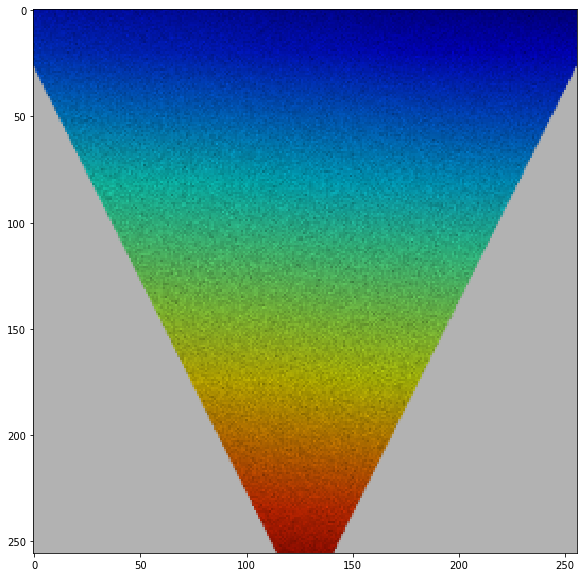

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(img.cpu())

In [13]:
def model(x):
    material.diffuse_reflectance = pyredner.Texture(x)
    serialized = pyredner.RenderFunction.serialize_scene(scene, 16, 1,
                                                    use_primary_edge_sampling=False, use_secondary_edge_sampling=False)
    return pyredner.RenderFunction.apply(0, *serialized)

In [14]:
color = torch.rand(10, 10, 3).cuda().requires_grad_(True)

In [15]:
optimizer = optim.Adam([color], lr=0.1)

In [16]:
for iteration in range(100):
    optimizer.zero_grad()
    gen = model(color)
    loss = ((gen - img)**2).mean()
    loss.backward()
    optimizer.step()
    print('Loss =', loss.item())

Loss = 0.051889657974243164
Loss = 0.03450736030936241
Loss = 0.021690746769309044
Loss = 0.013068193569779396
Loss = 0.007950196973979473
Loss = 0.005494385492056608
Loss = 0.004789709113538265
Loss = 0.0050119515508413315
Loss = 0.005541678052395582
Loss = 0.005929749459028244
Loss = 0.006011819001287222
Loss = 0.005758750718086958
Loss = 0.005238098558038473
Loss = 0.004570020828396082
Loss = 0.0038727778010070324
Loss = 0.003233701456338167
Loss = 0.0027211811393499374
Loss = 0.0023393710143864155
Loss = 0.0020515855867415667
Loss = 0.001862667384557426
Loss = 0.0017304110806435347
Loss = 0.0016099961940199137
Loss = 0.0014817643677815795
Loss = 0.001345652504824102
Loss = 0.0012070280499756336
Loss = 0.0010768836364150047
Loss = 0.0009660160867497325
Loss = 0.0008804348181001842
Loss = 0.000818735861685127
Loss = 0.0007722137379460037
Loss = 0.0007299635326489806
Loss = 0.0006816463428549469
Loss = 0.0006214592140167952
Loss = 0.0005486101727001369
Loss = 0.0004686419270001352
Los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


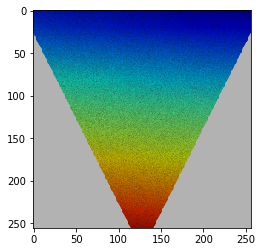

In [17]:
plt.imshow(model(color).cpu().detach())

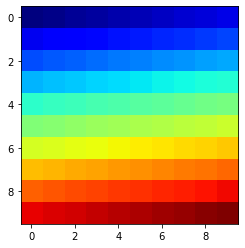

In [18]:
plt.imshow(ground_truth.cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


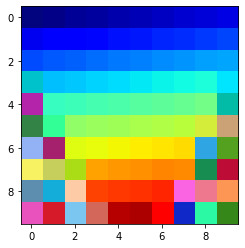

In [19]:
plt.imshow(color.detach().cpu())

In [20]:
color.grad

tensor([[[ 5.7248e-07,  4.8365e-07, -3.6270e-07],
         [ 3.0868e-06, -9.2966e-09, -1.6180e-06],
         [ 3.2694e-06, -1.8201e-06, -9.2700e-07],
         [ 1.9589e-06, -2.5725e-07, -1.8694e-06],
         [ 9.7417e-07, -5.0510e-07, -2.2804e-06],
         [-5.1822e-07, -1.9493e-06, -4.2611e-07],
         [-1.2922e-06, -1.4932e-06, -1.2052e-06],
         [-9.1863e-07, -1.8717e-06, -1.8211e-06],
         [-1.8742e-06,  1.1668e-06, -1.8516e-06],
         [-4.7634e-07,  2.5795e-07, -6.4164e-07]],

        [[ 8.5631e-07,  8.9692e-08, -6.6908e-07],
         [ 7.1343e-06, -2.7500e-06, -4.5076e-06],
         [ 9.6541e-06, -4.4407e-06, -7.5931e-06],
         [ 7.8683e-06,  2.4739e-06, -9.3892e-06],
         [ 4.6513e-06,  7.8749e-07, -9.5269e-06],
         [-3.8282e-06, -9.0238e-06, -5.9578e-06],
         [-5.1529e-06, -5.7474e-06, -5.9795e-06],
         [-7.6170e-07, -7.6037e-06, -6.2074e-06],
         [-2.2868e-06,  2.8204e-06, -4.4368e-06],
         [-8.9198e-07,  6.4060e-07, -1.3050e-06]

In [343]:
import pyredner
import torch

# Use GPU if available
pyredner.set_use_gpu(torch.cuda.is_available())

material_map, mesh_list, light_map = pyredner.load_obj('tutorials/teapot.obj')

for _, mesh in mesh_list:
    mesh.normals = pyredner.compute_vertex_normal(mesh.vertices, mesh.indices)

# Setup camera
cam = pyredner.Camera(
    position=torch.tensor([0.0, 30.0, 200.0]),
    look_at=torch.tensor([0.0, 30.0, 0.0]),
    up=torch.tensor([0.0, 1.0, 0.0]),
    fov=torch.tensor([45.0]),  # in degree
    clip_near=1e-2,  # needs to > 0
    resolution=(256, 256),
    fisheye=False)

material_id_map = {}
materials = []
count = 0
for key, value in material_map.items():
    material_id_map[key] = count
    count += 1
    materials.append(value)

shapes = []
for mtl_name, mesh in mesh_list:
    shapes.append(pyredner.Shape(\
        vertices = mesh.vertices,
        indices = mesh.indices,
        uvs = mesh.uvs,
        normals = mesh.normals,
        material_id = material_id_map[mtl_name]))

envmap = pyredner.imread('tutorials/sunsky.exr')
if pyredner.get_use_gpu():
    envmap = envmap.cuda()
envmap = pyredner.EnvironmentMap(envmap)

scene = pyredner.Scene(cam, shapes, materials, area_lights=[], envmap=envmap)
# Like the previous tutorial, we serialize and render the scene,
# save it as our target
scene_args = pyredner.RenderFunction.serialize_scene(\
    scene = scene,
    num_samples = 512,
    max_bounces = 1)
render = pyredner.RenderFunction.apply
img = render(0, *scene_args)
pyredner.imwrite(img.cpu(), 'results/texture_estimation/target.exr')
pyredner.imwrite(img.cpu(), 'results/texture_estimation/target.png')
target = pyredner.imread('results/texture_estimation/target.exr')
if pyredner.get_use_gpu():
    target = target.cuda()


# Init diffuse texture image
diffuse_reflectance = (0.5 * torch.ones([128, 128, 3],
                                 dtype=torch.float32,
                                 device=pyredner.get_device())).requires_grad_(True)
scene.materials[-1].diffuse_reflectance = pyredner.Texture(diffuse_reflectance)
# We need to serialize the scene again to get the new diffuse_reflectance
scene_args = pyredner.RenderFunction.serialize_scene(\
    scene = scene,
    num_samples = 512,
    max_bounces = 1)
# Render the initial guess.
img = render(1, *scene_args)
# Save the images.
pyredner.imwrite(img.cpu(), 'results/texture_estimation/init.png')
# Compute the difference and save the images.
diff = torch.abs(target - img)
pyredner.imwrite(diff.cpu(), 'results/texture_estimation/init_diff.png')

# Optimize for pose parameters.
optimizer = torch.optim.Adam([diffuse_reflectance], lr=1e-2)
# Run 200 Adam iterations.
for t in range(200):
    print('iteration:', t)
    optimizer.zero_grad()
    # Reassign the texture for differentiating mipmap construction
    scene.materials[-1].diffuse_reflectance = pyredner.Texture(diffuse_reflectance)
    # Forward pass: apply the mesh operation and render the image.
    scene_args = pyredner.RenderFunction.serialize_scene(\
        scene = scene,
        num_samples = 4, # We use less samples in the Adam loop.
        max_bounces = 1)
    # Important to use a different seed every iteration, otherwise the result
    # would be biased.
    img = render(t + 1, *scene_args)
    # Save the intermediate render.
    pyredner.imwrite(img.cpu(),
                     'results/texture_estimation/iter_{}.png'.format(t))
    # Compute the loss function. Here it is L2.
    loss = (img - target).pow(2).sum()
    print('loss:', loss.item())

    # Backpropagate the gradients.
    loss.backward()
    # Print the gradients
    print('texture.grad:', diffuse_reflectance.grad)

    # Take a gradient descent step.
    optimizer.step()
    # Print the current pose parameters.

# Render the final result.
scene_args = pyredner.RenderFunction.serialize_scene(\
    scene = scene,
    num_samples = 512,
    max_bounces = 1)
img = render(202, *scene_args)
# Save the images and differences.
pyredner.imwrite(img.cpu(), 'results/texture_estimation/final.exr')
pyredner.imwrite(img.cpu(), 'results/texture_estimation/final.png')
pyredner.imwrite(
    torch.abs(target - img).cpu(), 'results/texture_estimation/final_diff.png')

iteration: 0
loss: 46.57537078857422
texture.grad: tensor([[[-1.1113e-04,  0.0000e+00,  0.0000e+00],
         [-9.4115e-05,  0.0000e+00,  0.0000e+00],
         [-9.4115e-05,  0.0000e+00,  0.0000e+00],
         ...,
         [-1.2214e-04,  0.0000e+00,  0.0000e+00],
         [-1.1945e-04,  0.0000e+00,  0.0000e+00],
         [-1.2329e-04,  0.0000e+00,  0.0000e+00]],

        [[-1.0543e-04,  0.0000e+00,  0.0000e+00],
         [-8.8411e-05,  0.0000e+00,  0.0000e+00],
         [-8.8411e-05,  0.0000e+00,  0.0000e+00],
         ...,
         [-1.1760e-04,  0.0000e+00,  0.0000e+00],
         [-1.1494e-04,  0.0000e+00,  0.0000e+00],
         [-1.1846e-04,  0.0000e+00,  0.0000e+00]],

        [[-9.9600e-05,  0.0000e+00,  0.0000e+00],
         [-8.2996e-05,  0.0000e+00,  0.0000e+00],
         [-8.2996e-05,  0.0000e+00,  0.0000e+00],
         ...,
         [-1.0979e-04,  0.0000e+00,  0.0000e+00],
         [-1.0713e-04,  0.0000e+00,  0.0000e+00],
         [-1.0965e-04,  0.0000e+00,  0.0000e+00]],

 

KeyboardInterrupt: 